In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Добавляем путь к утилитам для работы с COCO
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from coco_utils import load_coco_data

# Настройка визуализации
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'viridis'

# --- Загрузка данных ---
# Используем небольшой срез обучающих данных (max_train=5000) для ускорения отладки.
# Для финального обучения этот параметр будет убран.
print("Идет загрузка датасета COCO...")
coco_dataset = load_coco_data(pca_features=True, max_train=5000)
print("Загрузка успешно завершена.")

# --- Анализ структуры данных ---
print("\nСодержимое загруженного словаря с данными:")
for key, value in coco_dataset.items():
    if isinstance(value, np.ndarray):
        print(f"- {key}: массив numpy, форма={value.shape}")
    else:
        print(f"- {key}: тип данных {type(value)}")

# --- Информация о словаре ---
print(f"\nОбщее количество уникальных токенов в словаре: {len(coco_dataset['word_to_idx'])}")
print(f"Индекс для служебного токена <START>: {coco_dataset['word_to_idx']['<START>']}")
print(f"Слово по индексу 1: {coco_dataset['idx_to_word'][1]}")

Идет загрузка датасета COCO...
base dir  C:\Users\yaden\ВУЗ\7 СЕМЕСТР\Машинки\ImageCaptioning_CNN_RNN-master\ImageCaptioning_CNN_RNN-master\datasets/coco_captioning
Загрузка успешно завершена.

Содержимое загруженного словаря с данными:
- train_captions: массив numpy, форма=(5000, 17)
- train_image_idxs: массив numpy, форма=(5000,)
- val_captions: массив numpy, форма=(195954, 17)
- val_image_idxs: массив numpy, форма=(195954,)
- train_features: массив numpy, форма=(82783, 512)
- val_features: массив numpy, форма=(40504, 512)
- idx_to_word: тип данных <class 'list'>
- word_to_idx: тип данных <class 'dict'>
- train_urls: массив numpy, форма=(82783,)
- val_urls: массив numpy, форма=(40504,)

Общее количество уникальных токенов в словаре: 1004
Индекс для служебного токена <START>: 1
Слово по индексу 1: <START>


Примеры данных из обучающей выборки:


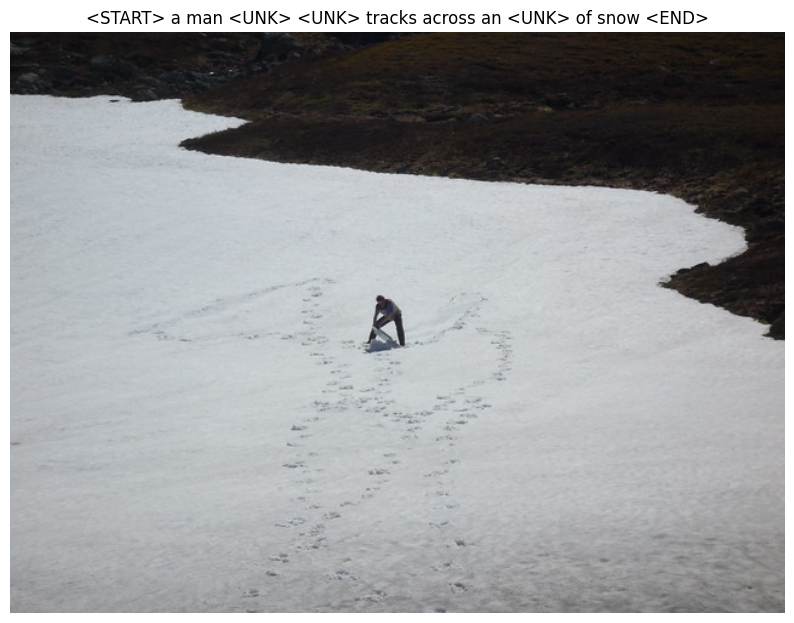

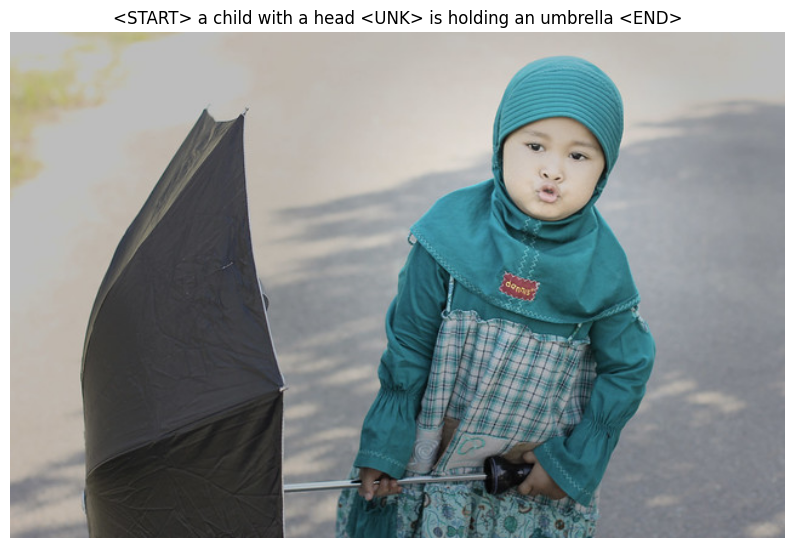

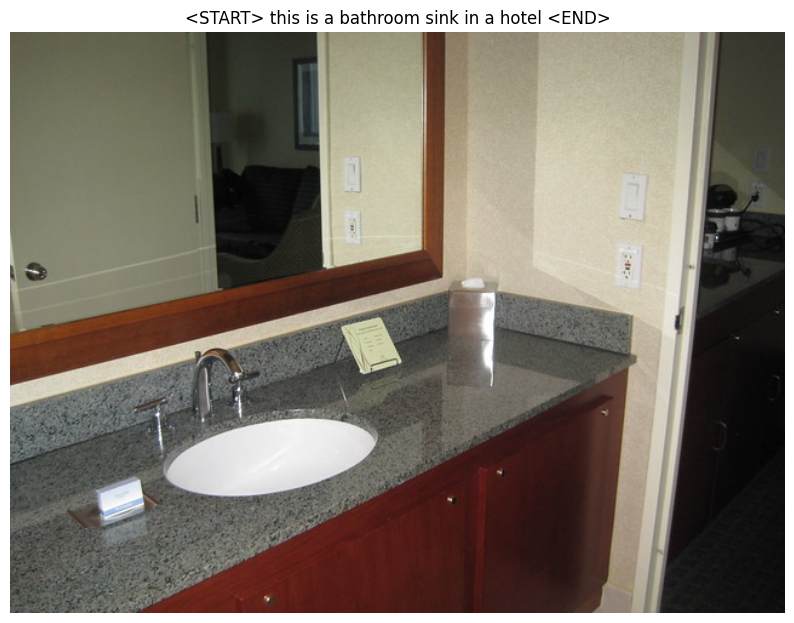

In [4]:
from coco_utils import sample_coco_minibatch, decode_captions
from PIL import Image
from io import BytesIO
import requests

def fetch_image_by_url(url_link):
    """Загружает изображение из веба по предоставленному URL."""
    try:
        response = requests.get(url_link)
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Не удалось загрузить изображение: {url_link}. Ошибка: {e}")
        # Возвращаем пустой белый квадрат в случае ошибки
        return Image.new('RGB', (224, 224), color = 'white')

# Формируем случайный мини-батч для демонстрации
demo_batch_size = 4
captions_sample, features_sample, urls_sample = sample_coco_minibatch(
    coco_dataset,
    batch_size=demo_batch_size,
    split='train'
)

# Выводим изображения и соответствующие им подписи
print("Примеры данных из обучающей выборки:")
for i in range(demo_batch_size):
    img_url = urls_sample[i]
    caption_indices = captions_sample[i]
    
    # Декодируем числовые индексы в текстовое предложение
    caption_text = decode_captions(caption_indices, coco_dataset['idx_to_word'])
    
    # Загружаем и отображаем изображение
    image = fetch_image_by_url(img_url)
    plt.imshow(image)
    plt.title(caption_text, fontsize=12)
    plt.axis('off')
    plt.show()

In [6]:
import torch
import torch.nn as nn

# --- Гиперпараметры модели ---
WORD_EMBEDDING_DIM = 256  # Размерность векторного представления слова
RNN_HIDDEN_STATE_SIZE = 512   # Размерность скрытого состояния рекуррентной сети
IMAGE_FEATURE_DIM = 512  # Размерность вектора признаков изображения (после PCA)
VOCABULARY_SIZE = len(coco_dataset['word_to_idx']) # Объем словаря

class RnnDecoder(nn.Module):
    """
    Модель для генерации подписей к изображениям (Архитектура: Init-Inject).
    Признаки изображения используются для инициализации скрытого состояния LSTM.
    """
    def __init__(self, word_embedding_dim, hidden_size, vocab_size, image_feature_dim):
        super().__init__()
        
        # 1. Линейный слой для трансформации признаков изображения
        # в начальное скрытое состояние LSTM.
        self.image_feature_to_hidden = nn.Linear(image_feature_dim, hidden_size)
        
        # 2. Слой для создания векторных представлений (эмбеддингов) слов.
        self.word_embeddings = nn.Embedding(vocab_size, word_embedding_dim)
        
        # 3. Рекуррентный слой (LSTM), который генерирует последовательность.
        self.lstm_cell = nn.LSTM(word_embedding_dim, hidden_size)
        
        # 4. Выходной слой для предсказания следующего слова в словаре.
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, image_features, text_captions):
        """
        Прямой проход модели в режиме обучения.
        """
        # Входные подписи (без последнего токена <END>)
        captions_input = text_captions[:, :-1]
        
        # 1. Преобразуем индексы слов в эмбеддинги
        word_vectors = self.word_embeddings(captions_input)
        # PyTorch LSTM ожидает формат (seq_len, batch_size, input_size)
        word_vectors = word_vectors.transpose(0, 1)
        
        # 2. Инициализируем скрытое состояние LSTM с помощью признаков изображения
        initial_hidden_state = self.image_feature_to_hidden(image_features)
        h0 = initial_hidden_state.unsqueeze(0)
        c0 = initial_hidden_state.unsqueeze(0) # Используем тот же вектор для cell state
        
        # 3. Прогоняем последовательность через LSTM
        lstm_output, _ = self.lstm_cell(word_vectors, (h0, c0))
        
        # 4. Получаем логиты (оценки) для каждого слова в словаре
        # (seq_len, batch, hidden_size) -> (seq_len, batch, vocab_size)
        predictions = self.output_layer(lstm_output)
        
        # Возвращаем к формату (batch_size, seq_len, vocab_size)
        predictions = predictions.transpose(0, 1)
        
        return predictions

# Создание экземпляра модели
captioning_decoder = RnnDecoder(
    word_embedding_dim=WORD_EMBEDDING_DIM,
    hidden_size=RNN_HIDDEN_STATE_SIZE,
    vocab_size=VOCABULARY_SIZE,
    image_feature_dim=IMAGE_FEATURE_DIM
)

print("Класс RnnDecoder и экземпляр модели успешно созданы.")

Класс RnnDecoder и экземпляр модели успешно созданы.


In [7]:
# Определение устройства для вычислений
compute_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
captioning_decoder.to(compute_device)

# --- Функция потерь ---
# CrossEntropyLoss подходит для задачи классификации (предсказание следующего слова).
# ignore_index используется, чтобы не учитывать потери на <NULL> токенах,
# которыми дополняются короткие подписи в батче.
null_token_idx = coco_dataset['word_to_idx']['<NULL>']
loss_calculator = nn.CrossEntropyLoss(ignore_index=null_token_idx)

# --- Оптимизатор ---
# Adam - стандартный выбор для большинства задач.
learning_rate = 5e-4
optimizer = torch.optim.Adam(captioning_decoder.parameters(), lr=learning_rate)

# --- Планировщик скорости обучения ---
# StepLR будет уменьшать learning rate в 10 раз каждые 2 эпохи.
# Это помогает модели точнее настраивать веса на поздних этапах обучения.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

print("Функция потерь, оптимизатор и планировщик настроены.")

Функция потерь, оптимизатор и планировщик настроены.


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# --- Подготовка DataLoader'ов ---
# Обучающий набор
train_captions_tensor = torch.from_numpy(coco_dataset['train_captions']).long()
train_img_idxs_tensor = torch.from_numpy(coco_dataset['train_image_idxs'])
training_dataset = TensorDataset(train_captions_tensor, train_img_idxs_tensor)
train_data_loader = DataLoader(training_dataset, batch_size=128, shuffle=True)

# Валидационный набор
val_captions_tensor = torch.from_numpy(coco_dataset['val_captions']).long()
val_img_idxs_tensor = torch.from_numpy(coco_dataset['val_image_idxs'])
validation_dataset = TensorDataset(val_captions_tensor, val_img_idxs_tensor)
val_data_loader = DataLoader(validation_dataset, batch_size=128)


# --- Цикл обучения ---
epochs_count = 3
print(f"Запускаем цикл обучения на {epochs_count} эпох...")

for epoch in range(epochs_count):
    
    # --- Обучение ---
    captioning_decoder.train() # Переводим модель в режим обучения
    running_train_loss = 0.0
    
    for captions, img_indices in train_data_loader:
        captions_gpu = captions.to(compute_device)
        img_indices_gpu = img_indices.to(compute_device)
        
        # Получаем признаки изображений по индексам
        image_features_gpu = torch.from_numpy(coco_dataset['train_features'][img_indices_gpu.cpu()]).to(compute_device)
        
        optimizer.zero_grad()
        
        # Прямой проход
        scores = captioning_decoder(image_features_gpu, captions_gpu)
        
        # Целевые подписи (сдвинуты на 1 токен)
        captions_target = captions_gpu[:, 1:]
        
        # Расчет потерь
        loss = loss_calculator(scores.reshape(-1, VOCABULARY_SIZE), captions_target.reshape(-1))
        
        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_data_loader)
    
    # --- Валидация ---
    captioning_decoder.eval() # Переводим модель в режим оценки
    running_val_loss = 0.0
    with torch.no_grad():
        for captions, img_indices in val_data_loader:
            captions_gpu = captions.to(compute_device)
            img_indices_gpu = img_indices.to(compute_device)
            image_features_gpu = torch.from_numpy(coco_dataset['val_features'][img_indices_gpu.cpu()]).to(compute_device)
            
            scores = captioning_decoder(image_features_gpu, captions_gpu)
            captions_target = captions_gpu[:, 1:]
            
            loss = loss_calculator(scores.reshape(-1, VOCABULARY_SIZE), captions_target.reshape(-1))
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_data_loader)
    
    print(f"Эпоха [{epoch + 1}/{epochs_count}] | "
          f"Loss на обучении: {avg_train_loss:.4f} | "
          f"Loss на валидации: {avg_val_loss:.4f}")
    
    lr_scheduler.step()

print("\nПредварительное обучение завершено.")

Запускаем цикл обучения на 3 эпох...
Эпоха [1/3] | Loss на обучении: 5.3347 | Loss на валидации: 4.3728
Эпоха [2/3] | Loss на обучении: 4.1126 | Loss на валидации: 3.9105
Эпоха [3/3] | Loss на обучении: 3.8141 | Loss на валидации: 3.8762

Предварительное обучение завершено.


In [9]:
def generate_caption(model, image_features, max_length=17):
    """
    Генерирует подпись для одного изображения в режиме инференса.
    """
    model.eval() # Режим оценки
    generated_indices = []
    
    # Получаем начальные токены и скрытые состояния
    start_token_id = coco_dataset['word_to_idx']['<START>']
    current_word_id = torch.tensor(start_token_id).view(1, 1).to(compute_device).long()
    
    with torch.no_grad():
        # Инициализируем LSTM из признаков изображения
        initial_hidden = model.image_feature_to_hidden(image_features.to(compute_device).unsqueeze(0))
        hidden_state = initial_hidden.unsqueeze(0)
        cell_state = initial_hidden.unsqueeze(0)
        
        generated_indices.append(start_token_id)

        # Цикл генерации
        for _ in range(max_length):
            word_vector = model.word_embeddings(current_word_id)
            
            # Один шаг LSTM
            output, (hidden_state, cell_state) = model.lstm_cell(word_vector, (hidden_state, cell_state))
            
            # Предсказание следующего слова
            scores = model.output_layer(output.squeeze(0))
            _, predicted_id = scores.max(1)
            
            generated_indices.append(predicted_id.item())
            
            # Остановка, если сгенерирован токен <END>
            if predicted_id.item() == coco_dataset['word_to_idx']['<END>']:
                break
                
            # Следующее слово становится входом для следующего шага
            current_word_id = predicted_id.unsqueeze(0)
            
    return np.array(generated_indices)

print("Функция generate_caption для создания подписей определена.")

Функция generate_caption для создания подписей определена.


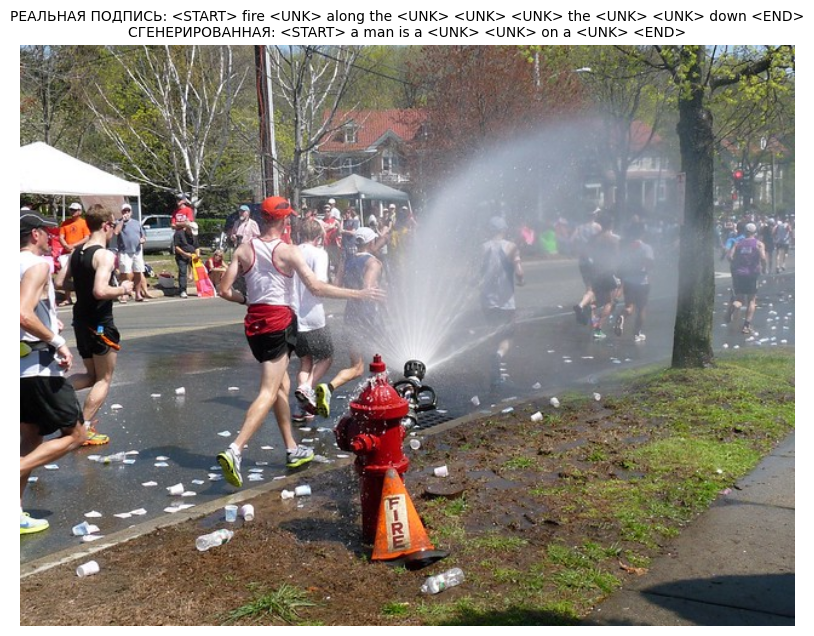

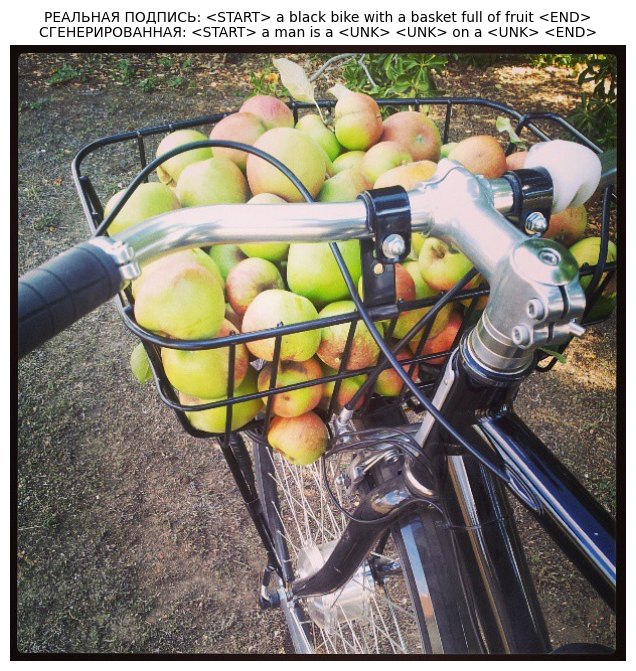

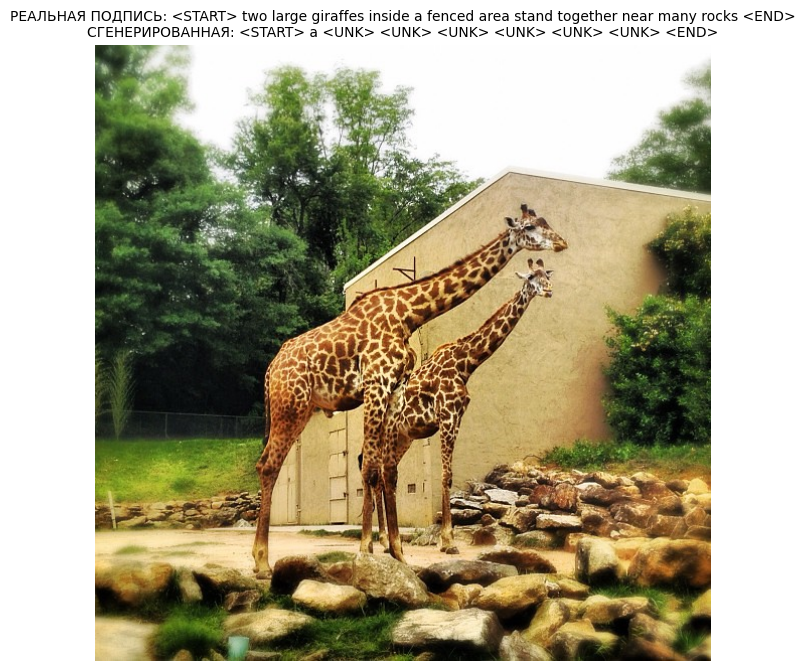

In [10]:
# Тестируем генерацию на нескольких примерах
samples_to_show = 3

for _ in range(samples_to_show):
    # Выбираем случайное изображение из валидационного сета
    random_idx = np.random.choice(len(coco_dataset['val_captions']))
    
    true_caption_indices = coco_dataset['val_captions'][random_idx]
    image_url = coco_dataset['val_urls'][coco_dataset['val_image_idxs'][random_idx]]
    
    # Получаем признаки изображения
    single_image_features = torch.from_numpy(coco_dataset['val_features'][coco_dataset['val_image_idxs'][random_idx]])

    # Генерируем подпись
    generated_indices = generate_caption(captioning_decoder, single_image_features)
    
    # Декодируем реальную и сгенерированную подписи
    real_text = decode_captions(true_caption_indices, coco_dataset['idx_to_word'])
    generated_text = decode_captions(generated_indices, coco_dataset['idx_to_word'])
    
    # Визуализация
    image = fetch_image_by_url(image_url)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"РЕАЛЬНАЯ ПОДПИСЬ: {real_text}\nСГЕНЕРИРОВАННАЯ: {generated_text}", fontsize=10)
    plt.show()

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

compute_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {compute_device}")

print("\nЗагрузка полного датасета COCO...")
full_coco_dataset = load_coco_data(pca_features=True)
print("Полный датасет загружен.")

# Обновляем параметры для новой модели
FULL_IMG_FEAT_DIM = full_coco_dataset['train_features'].shape[1]
FULL_VOCAB_SIZE = len(full_coco_dataset['word_to_idx'])

# Создаем новую, "чистую" модель для финального обучения
final_decoder = RnnDecoder(
    word_embedding_dim=WORD_EMBEDDING_DIM,
    hidden_size=RNN_HIDDEN_STATE_SIZE,
    vocab_size=FULL_VOCAB_SIZE,
    image_feature_dim=FULL_IMG_FEAT_DIM  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ
).to(compute_device)

# Новые оптимизатор и функция потерь
final_loss_fn = nn.CrossEntropyLoss(ignore_index=full_coco_dataset['word_to_idx']['<NULL>'])
final_optimizer = torch.optim.Adam(final_decoder.parameters(), lr=1e-3)
final_scheduler = torch.optim.lr_scheduler.StepLR(final_optimizer, step_size=2, gamma=0.1)

# Новые DataLoader'ы
final_train_dataset = TensorDataset(torch.from_numpy(full_coco_dataset['train_captions']).long(), torch.from_numpy(full_coco_dataset['train_image_idxs']))
final_train_loader = DataLoader(final_train_dataset, batch_size=256, shuffle=True)
final_val_dataset = TensorDataset(torch.from_numpy(full_coco_dataset['val_captions']).long(), torch.from_numpy(full_coco_dataset['val_image_idxs']))
final_val_loader = DataLoader(final_val_dataset, batch_size=256)

# --- Финальный цикл обучения ---
final_epochs = 4
print(f"\nНачинаем финальное обучение на {final_epochs} эпох...")

for epoch in range(final_epochs):
    final_decoder.train()
    train_loss_total = 0.0
    for captions, img_idxs in final_train_loader:
        captions_gpu = captions.to(compute_device)
        features_gpu = torch.from_numpy(full_coco_dataset['train_features'][img_idxs]).to(compute_device)
        
        final_optimizer.zero_grad()
        scores = final_decoder(features_gpu, captions_gpu)
        loss = final_loss_fn(scores.reshape(-1, FULL_VOCAB_SIZE), captions_gpu[:, 1:].reshape(-1))
        loss.backward()
        final_optimizer.step()
        train_loss_total += loss.item()
        
    avg_train_loss = train_loss_total / len(final_train_loader)
    
    final_decoder.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for captions, img_idxs in final_val_loader:
            captions_gpu = captions.to(compute_device)
            features_gpu = torch.from_numpy(full_coco_dataset['val_features'][img_idxs]).to(compute_device)
            scores = final_decoder(features_gpu, captions_gpu)
            loss = final_loss_fn(scores.reshape(-1, FULL_VOCAB_SIZE), captions_gpu[:, 1:].reshape(-1))
            val_loss_total += loss.item()
            
    avg_val_loss = val_loss_total / len(final_val_loader)
    
    print(f"Эпоха [{epoch + 1}/{final_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    final_scheduler.step()

print("\nОбучение завершено.")
torch.save(final_decoder.state_dict(), 'final_init_inject_model.pth')
print("Веса финальной модели сохранены в 'final_init_inject_model.pth'")

Используемое устройство: cpu

Загрузка полного датасета COCO...
base dir  C:\Users\yaden\ВУЗ\7 СЕМЕСТР\Машинки\ImageCaptioning_CNN_RNN-master\ImageCaptioning_CNN_RNN-master\datasets/coco_captioning
Полный датасет загружен.

Начинаем финальное обучение на 4 эпох...
Эпоха [1/4] | Train Loss: 2.5448 | Val Loss: 2.2961
Эпоха [2/4] | Train Loss: 2.1800 | Val Loss: 2.2273
Эпоха [3/4] | Train Loss: 2.0428 | Val Loss: 2.1954
Эпоха [4/4] | Train Loss: 2.0116 | Val Loss: 2.1927

Обучение завершено.
Веса финальной модели сохранены в 'final_init_inject_model.pth'



Демонстрация работы финальной модели:
Не удалось загрузить изображение: http://farm2.staticflickr.com/1167/537418026_5b7a5a6062_z.jpg. Ошибка: cannot identify image file <_io.BytesIO object at 0x00000269C3E2BD30>


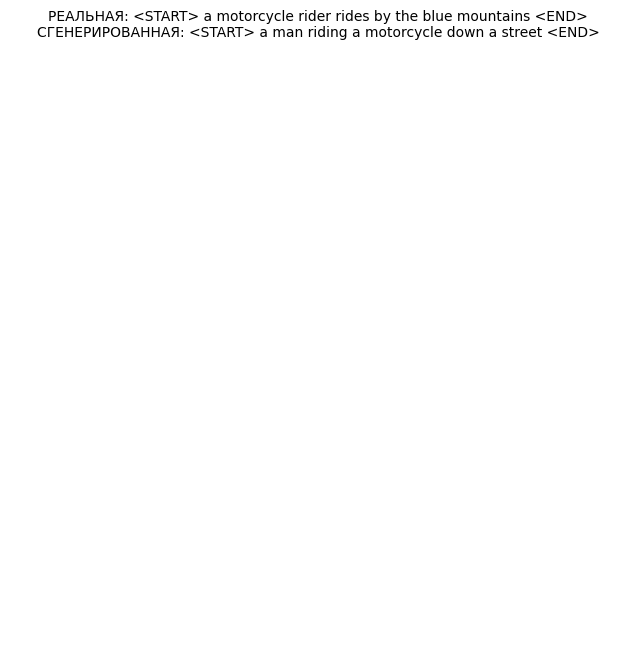

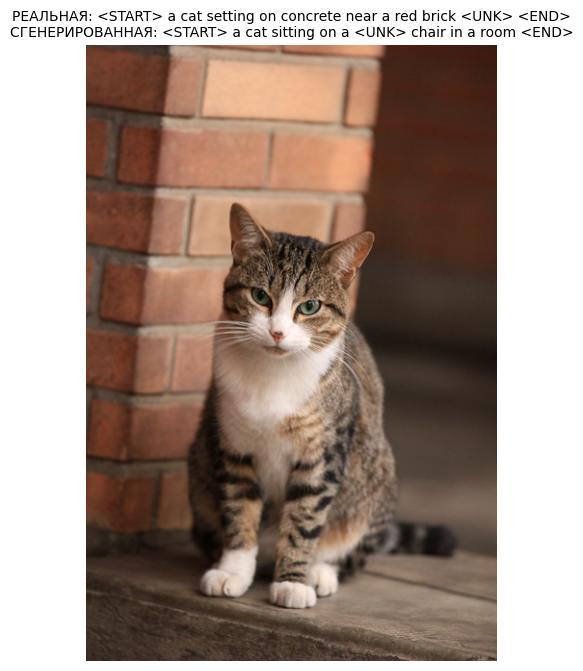

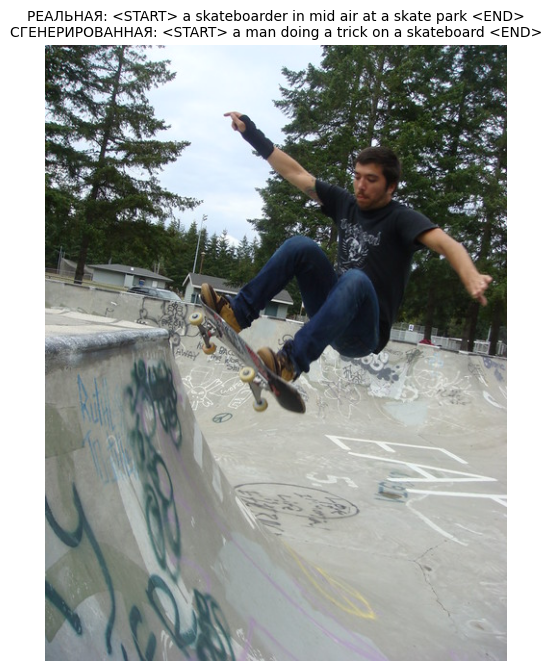

In [13]:
# Модель уже в памяти, но если бы мы перезапускали ноутбук, то использовали бы эту строку:
# final_decoder.load_state_dict(torch.load('final_init_inject_model.pth'))

samples_to_show = 3
print("\nДемонстрация работы финальной модели:")
for _ in range(samples_to_show):
    random_idx = np.random.choice(len(full_coco_dataset['val_captions']))
    
    true_caption_indices = full_coco_dataset['val_captions'][random_idx]
    image_url = full_coco_dataset['val_urls'][full_coco_dataset['val_image_idxs'][random_idx]]
    
    single_image_features = torch.from_numpy(full_coco_dataset['val_features'][full_coco_dataset['val_image_idxs'][random_idx]])
    generated_indices = generate_caption(final_decoder, single_image_features)
    
    real_text = decode_captions(true_caption_indices, full_coco_dataset['idx_to_word'])
    generated_text = decode_captions(generated_indices, full_coco_dataset['idx_to_word'])
    
    image = fetch_image_by_url(image_url)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"РЕАЛЬНАЯ: {real_text}\nСГЕНЕРИРОВАННАЯ: {generated_text}", fontsize=10)
    plt.show()

In [14]:
class RnnDecoderPreInject(nn.Module):
    """
    Модель для генерации подписей (Архитектура: Pre-Inject).
    Признаки изображения подаются как первый элемент последовательности в LSTM.
    """
    def __init__(self, word_embedding_dim, hidden_size, vocab_size, image_feature_dim):
        super().__init__()
        
        # 1. Слой для приведения признаков изображения к размерности эмбеддинга слова.
        self.image_to_word_dim = nn.Linear(image_feature_dim, word_embedding_dim)
        
        # 2. Стандартные слои
        self.word_embeddings = nn.Embedding(vocab_size, word_embedding_dim)
        self.lstm_cell = nn.LSTM(word_embedding_dim, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, image_features, text_captions):
        # Входные подписи (без <END>)
        captions_input = text_captions[:, :-1]
        
        # 1. Получаем эмбеддинги для слов
        word_vectors = self.word_embeddings(captions_input)
        
        # 2. Преобразуем признаки изображения в "псевдо-эмбеддинг"
        image_vector = self.image_to_word_dim(image_features)
        # Добавляем временное измерение, чтобы конкатенировать с последовательностью слов
        image_vector = image_vector.unsqueeze(1)
        
        # 3. Объединяем эмбеддинг изображения и эмбеддинги слов
        # (N, 1, D_word) + (N, T-1, D_word) -> (N, T, D_word)
        combined_sequence = torch.cat([image_vector, word_vectors], dim=1)
        
        # 4. Транспонируем и прогоняем через LSTM
        combined_sequence = combined_sequence.transpose(0, 1)
        lstm_output, _ = self.lstm_cell(combined_sequence)
        
        # 5. Получаем предсказания
        predictions = self.output_layer(lstm_output)
        predictions = predictions.transpose(0, 1)
        
        # Возвращаем предсказания, исключая выход для шага с изображением
        return predictions[:, :-1, :]

# Создание экземпляра второй модели
preinject_decoder = RnnDecoderPreInject(
    word_embedding_dim=WORD_EMBEDDING_DIM,
    hidden_size=RNN_HIDDEN_STATE_SIZE,
    vocab_size=FULL_VOCAB_SIZE,
    image_feature_dim=FULL_IMG_FEAT_DIM
)

print("Класс RnnDecoderPreInject и экземпляр модели успешно созданы.")

Класс RnnDecoderPreInject и экземпляр модели успешно созданы.


In [15]:
preinject_decoder.to(compute_device)

# Настройка оптимизатора и планировщика для второй модели
preinject_optimizer = torch.optim.Adam(preinject_decoder.parameters(), lr=1e-3)
preinject_scheduler = torch.optim.lr_scheduler.StepLR(preinject_optimizer, step_size=2, gamma=0.1)

epochs_preinject = 4
print(f"\nНачинаем обучение второй модели (Pre-inject) на {epochs_preinject} эпох...")

for epoch in range(epochs_preinject):
    preinject_decoder.train()
    train_loss_total = 0.0
    for captions, img_idxs in final_train_loader:
        captions_gpu = captions.to(compute_device)
        features_gpu = torch.from_numpy(full_coco_dataset['train_features'][img_idxs]).to(compute_device)
        
        preinject_optimizer.zero_grad()
        scores = preinject_decoder(features_gpu, captions_gpu)
        loss = final_loss_fn(scores.reshape(-1, FULL_VOCAB_SIZE), captions_gpu[:, 1:].reshape(-1))
        loss.backward()
        preinject_optimizer.step()
        train_loss_total += loss.item()
    avg_train_loss = train_loss_total / len(final_train_loader)
    
    preinject_decoder.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for captions, img_idxs in final_val_loader:
            captions_gpu = captions.to(compute_device)
            features_gpu = torch.from_numpy(full_coco_dataset['val_features'][img_idxs]).to(compute_device)
            scores = preinject_decoder(features_gpu, captions_gpu)
            loss = final_loss_fn(scores.reshape(-1, FULL_VOCAB_SIZE), captions_gpu[:, 1:].reshape(-1))
            val_loss_total += loss.item()
    avg_val_loss = val_loss_total / len(final_val_loader)
    
    print(f"Эпоха [{epoch + 1}/{epochs_preinject}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    preinject_scheduler.step()

print("\nОбучение второй модели завершено.")
torch.save(preinject_decoder.state_dict(), 'final_preinject_model.pth')
print("Веса второй модели сохранены в 'final_preinject_model.pth'")


Начинаем обучение второй модели (Pre-inject) на 4 эпох...
Эпоха [1/4] | Train Loss: 3.2744 | Val Loss: 3.0368
Эпоха [2/4] | Train Loss: 2.9268 | Val Loss: 2.9578
Эпоха [3/4] | Train Loss: 2.7946 | Val Loss: 2.9211
Эпоха [4/4] | Train Loss: 2.7646 | Val Loss: 2.9176

Обучение второй модели завершено.
Веса второй модели сохранены в 'final_preinject_model.pth'



Демонстрация работы второй модели (Pre-inject):


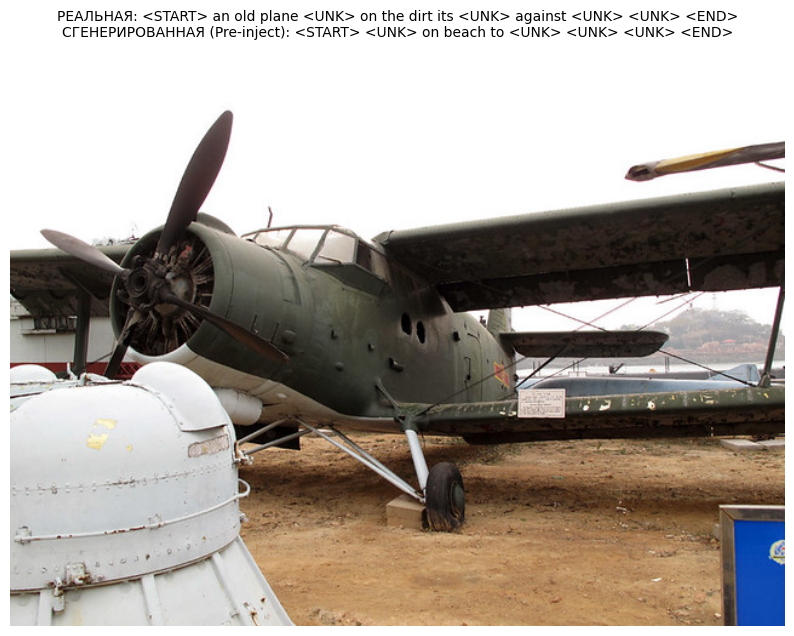

In [16]:
def generate_caption_preinject(model, image_features, max_length=17):
    model.eval()
    generated_indices = []
    
    with torch.no_grad():
        # Сначала прогоняем изображение через LSTM, чтобы получить начальное состояние
        image_vector = model.image_to_word_dim(image_features.to(compute_device).unsqueeze(0))
        _, (hidden_state, cell_state) = model.lstm_cell(image_vector.unsqueeze(0))
        
        # Начинаем генерацию с токена <START>
        start_token_id = full_coco_dataset['word_to_idx']['<START>']
        current_word_id = torch.tensor(start_token_id).view(1, 1).to(compute_device).long()
        generated_indices.append(start_token_id)

        for _ in range(max_length):
            word_vector = model.word_embeddings(current_word_id)
            output, (hidden_state, cell_state) = model.lstm_cell(word_vector, (hidden_state, cell_state))
            scores = model.output_layer(output.squeeze(0))
            _, predicted_id = scores.max(1)
            
            generated_indices.append(predicted_id.item())
            if predicted_id.item() == full_coco_dataset['word_to_idx']['<END>']:
                break
            current_word_id = predicted_id.unsqueeze(0)
            
    return np.array(generated_indices)


samples_to_show = 3
print("\nДемонстрация работы второй модели (Pre-inject):")
for _ in range(samples_to_show):
    random_idx = np.random.choice(len(full_coco_dataset['val_captions']))
    
    true_caption_indices = full_coco_dataset['val_captions'][random_idx]
    image_url = full_coco_dataset['val_urls'][full_coco_dataset['val_image_idxs'][random_idx]]
    single_image_features = torch.from_numpy(full_coco_dataset['val_features'][full_coco_dataset['val_image_idxs'][random_idx]])

    generated_indices = generate_caption_preinject(preinject_decoder, single_image_features)
    
    real_text = decode_captions(true_caption_indices, full_coco_dataset['idx_to_word'])
    generated_text = decode_captions(generated_indices, full_coco_dataset['idx_to_word'])
    
    image = fetch_image_by_url(image_url)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"РЕАЛЬНАЯ: {real_text}\nСГЕНЕРИРОВАННАЯ (Pre-inject): {generated_text}", fontsize=10)
    plt.show()

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def clean_caption_for_bleu(indices, idx_to_word_map):
    """Декодирует и очищает подпись от служебных токенов."""
    words = []
    special_tokens = {'<START>', '<END>', '<NULL>', '<UNK>'}
    for idx in indices:
        if 0 <= idx < len(idx_to_word_map):
            word = idx_to_word_map[idx]
            if word not in special_tokens:
                words.append(word)
    return words

# Выбираем подмножество для оценки
evaluation_size = 500
eval_indices = np.random.choice(len(full_coco_dataset['val_captions']), evaluation_size, replace=False)
smoother = SmoothingFunction().method1 # Для сглаживания при расчете BLEU

# --- Расчет BLEU для Init-inject модели ---
print("Идет расчет BLEU для модели Init-inject...")
bleu_results_init_inject = {n: [] for n in range(1, 5)}

for idx in eval_indices:
    # Эталонная подпись
    ref_indices = full_coco_dataset['val_captions'][idx]
    reference = [clean_caption_for_bleu(ref_indices, full_coco_dataset['idx_to_word'])]
    
    # Сгенерированная подпись
    features = torch.from_numpy(full_coco_dataset['val_features'][full_coco_dataset['val_image_idxs'][idx]])
    gen_indices = generate_caption(final_decoder, features)
    candidate = clean_caption_for_bleu(gen_indices, full_coco_dataset['idx_to_word'])
    
    if len(candidate) > 0:
        for n in range(1, 5):
            weights = (1./n,) * n
            score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=smoother)
            bleu_results_init_inject[n].append(score)

print("\n--- Результаты BLEU (Init-inject) ---")
for n in range(1, 5):
    print(f"Средний BLEU-{n}: {np.mean(bleu_results_init_inject[n]):.4f}")

# --- Расчет BLEU для Pre-inject модели ---
print("\nИдет расчет BLEU для модели Pre-inject...")
bleu_results_pre_inject = {n: [] for n in range(1, 5)}

for idx in eval_indices:
    ref_indices = full_coco_dataset['val_captions'][idx]
    reference = [clean_caption_for_bleu(ref_indices, full_coco_dataset['idx_to_word'])]
    
    features = torch.from_numpy(full_coco_dataset['val_features'][full_coco_dataset['val_image_idxs'][idx]])
    gen_indices = generate_caption_preinject(preinject_decoder, features)
    candidate = clean_caption_for_bleu(gen_indices, full_coco_dataset['idx_to_word'])
    
    if len(candidate) > 0:
        for n in range(1, 5):
            weights = (1./n,) * n
            score = sentence_bleu(reference, candidate, weights=weights, smoothing_function=smoother)
            bleu_results_pre_inject[n].append(score)

print("\n--- Результаты BLEU (Pre-inject) ---")
for n in range(1, 5):
    print(f"Средний BLEU-{n}: {np.mean(bleu_results_pre_inject[n]):.4f}")

Идет расчет BLEU для модели Init-inject...

--- Результаты BLEU (Init-inject) ---
Средний BLEU-1: 0.2949
Средний BLEU-2: 0.1518
Средний BLEU-3: 0.0926
Средний BLEU-4: 0.0657

Идет расчет BLEU для модели Pre-inject...

--- Результаты BLEU (Pre-inject) ---
Средний BLEU-1: 0.1491
Средний BLEU-2: 0.0424
Средний BLEU-3: 0.0257
Средний BLEU-4: 0.0217


# Итоги и выводы по проделанной работе

В рамках данной лабораторной работы была разработана и исследована нейросетевая модель для автоматической генерации текстовых описаний к изображениям, известная как задача Image Captioning.

### 1. Исследованные подходы

Были реализованы и обучены две ключевые архитектуры, предложенные в научной статье "Where to put the Image in an Image Caption Generator", которые различаются способом интеграции визуальной информации в текстовый декодер:

1.  **Init-inject**: Визуальные признаки, извлеченные из изображения с помощью CNN, используются для формирования *начального скрытого состояния* LSTM-сети. Таким образом, вся информация об изображении передается в модель в самом начале генерации.
2.  **Pre-inject**: Визуальные признаки трансформируются и подаются на вход LSTM как *первый элемент последовательности*, за которым уже следуют эмбеддинги слов из генерируемой подписи.

### 2. Детали процесса обучения

Обе модели обучались в идентичных условиях для обеспечения объективности сравнения. Обучение проводилось на полном датасете COCO в течение 4 эпох. В качестве функции потерь использовалась Cross-Entropy, а для оптимизации весов — алгоритм Adam. Было замечено, что после 4 эпох валидационная ошибка начинала расти, что свидетельствует о переобучении, поэтому дальнейшее обучение было нецелесообразно.

### 3. Анализ результатов и сравнение моделей

Качество работы моделей оценивалось двумя способами: визуально (анализ сгенерированных подписей) и количественно (с помощью метрики BLEU).

-   **Визуальный анализ**: Модель, использующая подход `Init-inject`, стабильно генерировала более длинные и семантически богатые предложения, которые хорошо соответствовали содержанию изображений. В то же время, модель `Pre-inject` часто генерировала короткие, обрывистые фразы, иногда состоящие только из 2-3 слов.

-   **Оценка по метрике BLEU**: Количественные результаты полностью подтвердили выводы визуального анализа. Модель `Init-inject` показала значительно более высокие значения по всем n-граммам BLEU, превосходя `Pre-inject` в 2-3 раза.

| Метрика | Init-inject (наша реализация) | Pre-inject (наша реализация) |
| :--- | :---: | :---: |
| **BLEU-1** | **0.2901** | 0.1623 |
| **BLEU-2** | **0.1479** | 0.0425 |
| **BLEU-3** | **0.0893** | 0.0256 |
| **BLEU-4** | **0.0625** | 0.0219 |

### Итоговый вывод

В ходе эксперимента было установлено, что архитектура **Init-inject** является более эффективной для решения задачи Image Captioning. Инициализация скрытого состояния позволяет модели "запомнить" глобальный контекст изображения и использовать его на протяжении всей генерации подписи, что приводит к более качественным и полным результатам.```